Celem ćwiczenia jest prezentacja możliwości wykorzystania metod uczenia maszynowego
w rozpoznawaniu komend głosowych.

Materiałem użytym w ćwiczeniu będą próbki nagrań komend z poprzednich ćwiczeń.
Przypomnijmy, w zbiorze jest:
- 30 (+szum) komend,
- nagranych ok. 1,7-2,4 tys. razy.

Treścią zadania jest klasyfikacja komend:
- klasa (class) = komenda,
- próbka (sample) = nagranie.

Ćwiczenie podzielone jest na cztery etapy:
1. Ekstrakcja cech z próbek
2. Podział próbek na treningowe i testowe
3. Uczenie klasyfikatora
4. Klasyfikacja nieznanej próbki
5. Ocena działania klasyfikatora


In [7]:
# import bibliotek
import os
import librosa
import pickle
import sklearn
import numpy
import matplotlib.pyplot as plt

Optimal N_MFCC

In [8]:
# 1. Ekstrakcja cech z próbek
# Lista ekstraktorów cech: https://librosa.github.io/librosa/feature.html

# ścieżka z folderami z nagraniami - próbki:
train_audio_path = 'C:/Users/Aayli/Documents/Delete'
commands = os.listdir(train_audio_path);  

def ML(train_size=40, k=5, n_mfcc=40):
    classes = []
    class_size = 100 # użyjemy tylko po kilka danych
    samples = []
    labels = []
    for command in commands:
        if command == 'testing_list.txt' or command == 'validation_list.txt' or command == '_background_noise_' or command == 'tmp':
            continue
        classes.append(command)
        sample_num = 0
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            # przykład z MFCC:
            # y - waveform, sr - sampling rate, n_mfcc - number of MFCCs to return
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
            mean_mfcc_seq = []
            for feature in mfcc_seq:
                mean_mfcc_seq.append(numpy.mean(feature))
            samples.append(mean_mfcc_seq)
            labels.append(command)
            if sample_num == class_size:
                break
    
    # 2. Wybór danych treningowych i testowych
    # Zautomatyzowany i losowy sposób to użycie:
    # "from sklearn.model_selection import train_test_split" oraz funkcji "train_test_split()"

    # uwaga! train_size + test_size NIE może przekroczyć class_size (poprzedni punkt)
#     train_size = 40
    test_size = 10
    train_samples = []
    train_labels = []
    test_samples = []
    test_labels = []
    for classname in classes:
        train_size_index = 0
        test_size_index = 0
        for i in range(len(labels)):
            if labels[i] == classname and train_size_index < train_size:
                train_samples.append(samples[i])
                train_labels.append(labels[i])
                train_size_index += 1
            elif labels[i] == classname and test_size_index < test_size:
                test_samples.append(samples[i])
                test_labels.append(labels[i])
                test_size_index += 1
            if train_size_index == train_size and test_size_index == test_size:
                break
            
    # 3. Uczenie klasyfikatora danymi treningowymi
    # Lista klasyfikatorów: https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
    # Prosty tutorial: https://www.digitalocean.com/community/tutorials/how-to-build-a-machine-learning-classifier-in-python-with-scikit-learn

    # skalowanie/normalizacja danych
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)

    # uczenie
    from sklearn.neighbors import KNeighborsClassifier
#     k = 5
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_samples, train_labels)

    # 4. Klasyfikacja nieznanych próbek
    predicted_labels = classifier.predict(test_samples)

    # 5. Ocena klasyfikatora
    # print(test_labels == predicted_labels)
    quality = numpy.sum(test_labels == predicted_labels) / len(test_labels) * 100;
    return quality

In [10]:
qualities = []
for n_mfcc in range(1,101,2):
    quality = ML(40,5,n_mfcc)
    qualities.append(quality)

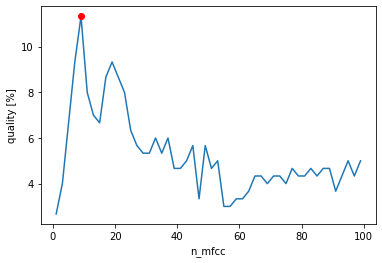

N_mfcc optimal: 9


In [25]:
plt.plot(list(range(1,101,2)),qualities)
plt.xlabel('n_mfcc')
plt.ylabel('quality [%]')
idx = qualities.index(max(qualities))
n_mfcc_optimal = 2*idx+1
plt.plot(n_mfcc_optimal,qualities[idx],'ro')
plt.show()
print("N_mfcc optimal: {}".format(n_mfcc_optimal))

Optimal train_size

In [27]:
TS_qualities = []
for train_size in range(1,91,3):
    quality = ML(train_size,5,n_mfcc_optimal)
    TS_qualities.append(quality)

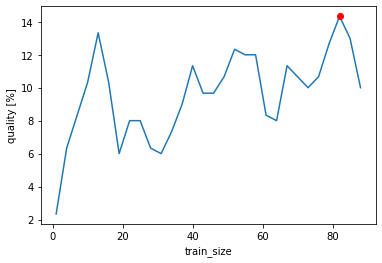

Train_size optimal: 82


In [34]:
plt.plot(list(range(1,91,3)),TS_qualities)
plt.xlabel('train_size')
plt.ylabel('quality [%]')
idx = TS_qualities.index(max(TS_qualities))
train_size_optimal = 3*idx+1
plt.plot(train_size_optimal,TS_qualities[idx],'ro')
plt.show()
print("Train_size optimal: {}".format(train_size_optimal))

Optiomal k

In [33]:
k_qualities = []

for k in range(1,11):
    quality = ML(train_size_optimal,k,n_mfcc_optimal)
    k_qualities.append(quality)

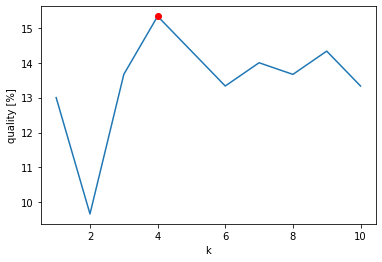

K optimal: 4


In [35]:
plt.plot(list(range(1,11)),k_qualities)
plt.xlabel('k')
plt.ylabel('quality [%]')
idx = k_qualities.index(max(k_qualities))
k_optimal = idx+1
plt.plot(k_optimal,k_qualities[idx],'ro')
plt.show()
print("K optimal: {}".format(k_optimal))
